In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# MVC 2D

In [92]:
def compute_mvc_2d(src_pts, cage_pts, eps=1e-12, edge_atol=1e-9, fix_orientation=True):
    """
    2D Mean Value Coordinates for cage (Floater, 2003).
    
    Args:
        src_pts (np.ndarray): (V, 2) points inside the cage
        cage_pts (np.ndarray): (Nc, 2) cage vertices (counter-clockwise)
        eps (float): small number
        edge_atol (float): (alpha ~ pi)
        fix_orientation (bool): change orientation to CCW
    Returns:
        W (np.ndarray): (V, Nc) MVC weights (rows sum to 1)
    """
    src_pts  = np.asarray(src_pts,  dtype=np.float64)
    cage_pts = np.asarray(cage_pts, dtype=np.float64)
    V, Nc = src_pts.shape[0], cage_pts.shape[0]
    W = np.zeros((V, Nc), dtype=np.float64)

    if fix_orientation:
        area2 = np.sum(cage_pts[:,0]*np.roll(cage_pts[:,1], -1) -
                       cage_pts[:,1]*np.roll(cage_pts[:,0], -1))
        if area2 < 0:
            cage_pts = cage_pts[::-1].copy()

    idx_next = (np.arange(Nc) + 1) % Nc

    for vi in range(V):
        x = src_pts[vi]
        d = cage_pts - x                          # (Nc,2)
        r = np.linalg.norm(d, axis=1)             # (Nc,)
        j = np.argmin(r)

        if r[j] < eps:
            e = np.zeros(Nc); e[j] = 1.0
            W[vi] = e; continue

        u = d / (r[:,None] + eps)                 # (Nc,2)
        un = u[idx_next]                          # (Nc,2)

        cos = np.clip((u * un).sum(axis=1), -1.0, 1.0)  # ⟨u_i, u_{i+1}⟩
        sin = u[:,0]*un[:,1] - u[:,1]*un[:,0]           # cross2D(u_i, u_{i+1})_z

        on_edge = (np.abs(cos + 1.0) < edge_atol) & (np.abs(sin) < edge_atol)
        if np.any(on_edge):
            k = int(np.where(on_edge)[0][0])
            i0, i1 = k, idx_next[k]
            v0, v1 = cage_pts[i0], cage_pts[i1]
            seg = v1 - v0
            t = np.dot(x - v0, seg) / (np.dot(seg, seg) + eps)
            t = np.clip(t, 0.0, 1.0)
            e = np.zeros(Nc); e[i0] = 1.0 - t; e[i1] = t
            W[vi] = e; continue

        # tan(theta/2) = sin / (1+cos)
        denom = 1.0 + cos
        denom = np.where(np.abs(denom) < 1e-15, np.sign(denom)*1e-15, denom)
        tan_half = sin / denom                     # (Nc,)
        tan_prev = tan_half[np.arange(Nc) - 1]
        w = (tan_prev + tan_half) / (r + eps)      # (Nc,)

        s = w.sum()
        if np.abs(s) < eps:
            w[:] = 1.0 / Nc
        else:
            w /= s

        W[vi] = w

    return W



## image forward mapping

In [ ]:
def bilinear_sample(img, xy):
    H, W, C = img.shape
    x = xy[:,0]
    y = xy[:,1]
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)
    Ia = img[y0, x0]
    Ib = img[y0, x1]
    Ic = img[y1, x0]
    Id = img[y1, x1]
    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)
    out = (Ia * wa[:,None] + Ib * wb[:,None] + Ic * wc[:,None] + Id * wd[:,None])
    return out

def forward_warp(img, dst_xy, out_size=None, mask=None, eps=1e-8):
    H, W, C = img.shape
    xy = dst_xy.reshape(-1, 2)
    if mask is None:
        m = np.ones((H, W), dtype=bool).reshape(-1)
    else:
        m = mask.reshape(-1).astype(bool)
    if out_size is None:
        xmin = np.floor(np.min(xy[m,0]))
        xmax = np.ceil (np.max(xy[m,0]))
        ymin = np.floor(np.min(xy[m,1]))
        ymax = np.ceil (np.max(xy[m,1]))
        H_out = max(int(ymax - ymin + 1), 1)
        W_out = max(int(xmax - xmin + 1), 1)
        xy = xy.copy()
        xy[:,0] -= xmin
        xy[:,1] -= ymin
    else:
        H_out, W_out = out_size
    out = np.zeros((H_out, W_out, C), dtype=np.float32)
    wsum = np.zeros((H_out, W_out), dtype=np.float32)
    colors = img.reshape(-1, C)
    x = xy[m, 0]; y = xy[m, 1]; col = colors[m]
    x0 = np.floor(x).astype(int); x1 = x0 + 1
    y0 = np.floor(y).astype(int); y1 = y0 + 1
    x0c = np.clip(x0, 0, W_out-1); x1c = np.clip(x1, 0, W_out-1)
    y0c = np.clip(y0, 0, H_out-1); y1c = np.clip(y1, 0, H_out-1)
    wa = (x1 - x) * (y1 - y)  # (x0,y0)
    wb = (x - x0) * (y1 - y)  # (x1,y0)
    wc = (x1 - x) * (y - y0)  # (x0,y1)
    wd = (x - x0) * (y - y0)  # (x1,y1)
    def add_at(img_accum, xs, ys, w, val):
        np.add.at(img_accum, (ys, xs), (w[:, None] * val))
    def add_at_w(waccum, xs, ys, w):
        np.add.at(waccum, (ys, xs), w)
    add_at(out, x0c, y0c, wa, col)
    add_at(out, x1c, y0c, wb, col)
    add_at(out, x0c, y1c, wc, col)
    add_at(out, x1c, y1c, wd, col)
    add_at_w(wsum, x0c, y0c, wa)
    add_at_w(wsum, x1c, y0c, wb)
    add_at_w(wsum, x0c, y1c, wc)
    add_at_w(wsum, x1c, y1c, wd)
    out = out / (wsum[..., None] + eps)
    return np.clip(out, 0, 1), wsum

def forward_warp_with_padding(img, dst_xy, out_size=None, mode='center', mask=None):
    H, W, _ = img.shape
    if out_size is None:
        H_out, W_out = H, W
    else:
        H_out, W_out = out_size
    if mask is None:
        m = np.ones((H, W), dtype=bool)
    else:
        m = mask.astype(bool)
    xy = dst_xy[m]
    if xy.size == 0:
        return np.zeros((H_out,W_out, img.shape[2]), dtype=img.dtype), np.zeros((H_out,W_out), dtype=np.float32), (0.0,0.0)
    xmin = float(np.floor(xy[:,0].min()))
    xmax = float(np.ceil (xy[:,0].max()))
    ymin = float(np.floor(xy[:,1].min()))
    ymax = float(np.ceil (xy[:,1].max()))
    bw = xmax - xmin + 1.0
    bh = ymax - ymin + 1.0
    if mode == 'center':
        tx = (W_out - bw) * 0.5 - xmin
        ty = (H_out - bh) * 0.5 - ymin
    else:
        tx = -xmin; ty = -ymin
    dst_shifted = dst_xy.copy()
    dst_shifted[...,0] = dst_xy[...,0] + tx
    dst_shifted[...,1] = dst_xy[...,1] + ty
    out, wsum = forward_warp(img, dst_shifted, out_size=(H_out, W_out), mask=mask)
    return out, wsum, (tx, ty)

def forward_warp_fixed_canvas(img, dst_xy, out_size=None, mask=None, eps=1e-8):
    H, W, C = img.shape
    
    if out_size is None:
        H_out, W_out = H, W
    else:
        H_out, W_out = out_size

    xy = dst_xy.reshape(-1, 2)
    colors = img.reshape(-1, C)

    if mask is None:
        m = np.ones((H*W,), dtype=bool)
    else:
        m = mask.reshape(-1).astype(bool)

    x = xy[m, 0]
    y = xy[m, 1]
    col = colors[m]

    x0 = np.floor(x).astype(int); x1 = x0 + 1
    y0 = np.floor(y).astype(int); y1 = y0 + 1

    wa = (x1 - x) * (y1 - y)  # (x0,y0)
    wb = (x - x0) * (y1 - y)  # (x1,y0)
    wc = (x1 - x) * (y - y0)  # (x0,y1)
    wd = (x - x0) * (y - y0)  # (x1,y1)

    out = np.zeros((H_out, W_out, C), dtype=np.float32)
    wsum = np.zeros((H_out, W_out), dtype=np.float32)

    def splat(neigh_x, neigh_y, w):
        valid = (neigh_x >= 0) & (neigh_x < W_out) & (neigh_y >= 0) & (neigh_y < H_out) & (w > 0)
        if not np.any(valid):
            return
        xs = neigh_x[valid]
        ys = neigh_y[valid]
        ww = w[valid][:, None]
        cc = col[valid]
        np.add.at(out, (ys, xs), ww * cc)
        np.add.at(wsum, (ys, xs), w[valid])

    splat(x0, y0, wa)
    splat(x1, y0, wb)
    splat(x0, y1, wc)
    splat(x1, y1, wd)

    out = out / (wsum[..., None] + eps)
    return np.clip(out, 0, 1), wsum

def box_blur(img, k=3):
    assert k % 2 == 1
    r = k // 2
    pad = np.pad(img, ((0,0),(r,r),(0,0)), mode='reflect')
    cumsum = np.cumsum(pad, axis=1)
    h = cumsum[:, 2*r+1:, :] - cumsum[:, :-2*r-1, :]
    h = h / float(k)
    pad = np.pad(h, ((r,r),(0,0),(0,0)), mode='reflect')
    cumsum = np.cumsum(pad, axis=0)
    v = cumsum[2*r+1:, :, :] - cumsum[:-2*r-1, :, :]
    v = v / float(k)
    return v

def downsample(x):
    return x[::2, ::2]

def upsample_bilinear(x, H, W):
    h, w, C = x.shape
    if h == H and w == W:
        return x.copy()
    ys = np.linspace(0, h-1, H)
    xs = np.linspace(0, w-1, W)
    yy, xx = np.meshgrid(ys, xs, indexing='ij')
    x0 = np.floor(xx).astype(int); x1 = np.clip(x0+1, 0, w-1)
    y0 = np.floor(yy).astype(int); y1 = np.clip(y0+1, 0, h-1)
    wx = (xx - x0)[..., None]; wy = (yy - y0)[..., None]  # (H,W,1)
    Ia = x[y0, x0]; Ib = x[y0, x1]; Ic = x[y1, x0]; Id = x[y1, x1]  # (H,W,C)
    out = (Ia*(1-wx)*(1-wy) + Ib*wx*(1-wy) + Ic*(1-wx)*wy + Id*wx*wy)
    return out

def inpaint_push_pull(img, wsum, levels=6, blur_k=5, eps=1e-8):
    H, W, C = img.shape
    w = wsum[..., None]
    iw = img * w
    iw_pyr = [iw.copy()]; w_pyr = [w.copy()]
    for _ in range(levels-1):
        iw_blur = box_blur(iw_pyr[-1], k=blur_k)
        w_blur  = box_blur(w_pyr[-1],  k=blur_k)
        iw_ds = downsample(iw_blur)
        w_ds  = downsample(w_blur)
        iw_pyr.append(iw_ds)
        w_pyr.append(w_ds)
        if iw_ds.shape[0] <= 1 or iw_ds.shape[1] <= 1:
            break
    acc = iw_pyr[-1]; wacc = w_pyr[-1]
    for lvl in range(len(iw_pyr)-2, -1, -1):
        ih = iw_pyr[lvl]; wh = w_pyr[lvl]
        acc_up  = upsample_bilinear(acc, ih.shape[0], ih.shape[1])
        wacc_up = upsample_bilinear(wacc, wh.shape[0], wh.shape[1])
        mask_hole = (wh <= eps).astype(acc_up.dtype)
        acc = ih + acc_up * mask_hole
        wacc = wh + wacc_up * mask_hole
    filled = acc / (wacc + eps)
    return np.clip(filled, 0, 1)

def forward_infill_warp_fixed_canvas(img, dst_xy, out_size=None, mask=None, levels=2, blur_k=5, eps=1e-8):
    H, W, C = img.shape
    
    if out_size is None:
        H_out, W_out = H, W
    else:
        H_out, W_out = out_size
        
    xy = dst_xy.reshape(-1, 2)
    colors = img.reshape(-1, C)
    if mask is None:
        m = np.ones((H*W,), dtype=bool)
    else:
        m = mask.reshape(-1).astype(bool)
    x = xy[m, 0]; y = xy[m, 1]; col = colors[m]
    x0 = np.floor(x).astype(int); x1 = x0 + 1
    y0 = np.floor(y).astype(int); y1 = y0 + 1
    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)
    out = np.zeros((H_out, W_out, C), dtype=np.float32)
    wsum = np.zeros((H_out, W_out), dtype=np.float32)
    def splat(nx, ny, w):
        valid = (nx >= 0) & (nx < W_out) & (ny >= 0) & (ny < H_out) & (w > 0)
        if not np.any(valid): return
        xs = nx[valid]; ys = ny[valid]; ww = w[valid][:, None]; cc = col[valid]
        np.add.at(out, (ys, xs), ww * cc); np.add.at(wsum, (ys, xs), w[valid])
    splat(x0, y0, wa); splat(x1, y0, wb); splat(x0, y1, wc); splat(x1, y1, wd)
    out = out / (wsum[..., None] + 1e-8)
    out = np.clip(out, 0, 1)
    out_filled = inpaint_push_pull(out, wsum, levels=levels, blur_k=blur_k)
    return out_filled, wsum



## Create cages

In [ ]:


# Create procedural RGB image
H, W = 360, 480
yy, xx = np.meshgrid(np.linspace(0,1,H), np.linspace(0,1,W), indexing='ij')
img = np.zeros((H, W, 3), dtype=np.float32)
img[...,0] = xx
img[...,1] = yy
img[...,2] = (np.sin(6*np.pi*xx)*np.cos(4*np.pi*yy)+1) * 0.5
img[...,0] -= img[...,2] *0.5
img[...,1] -= img[...,2] *0.5
print(img.shape)


# Source cage (octagon)
pad = 35
src_cage = np.array([
    [pad, pad],
    [W/2, 0+pad],
    [W-pad, pad],
    [W-pad, H/2],
    [W-pad, H-pad],
    [W/2, H-pad],
    [pad, H-pad],
    [pad, H/2],
], dtype=np.float64)
src_cage = src_cage * 0.9 + 15
# src_cage = src_cage * 0.35 + pad*4

# Deformed cage
deform = src_cage.copy() #* 1.2 - 0.6
deform[1] += np.array([-80,  30])
deform[3] += np.array([-20, -10])
deform[5] += np.array([-60, -30])
deform[7] += np.array([ 30, -20])


deform2 = src_cage.copy() *0.8 + 0.4*35
deform2[0] += np.array([80,  30])
deform2[2] += np.array([-20, -10])
deform2[4] += np.array([60, -30])
deform2[6] += np.array([ 30, 20])

def z_rotation_2D(angle):
    angle = np.pi * angle / 180.0
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[   c,        -s,        0.0],
                  [   s,         c,        0.0],
                  [ 0.0,       0.0,        1.0],], dtype=np.float32)
    return R


(360, 480, 3)


In [377]:

_cage_h = np.concatenate([deform2, np.ones((src_cage.shape[0],1))], axis=-1)
deform3 = _cage_h @ z_rotation_2D(60)
deform3 = deform3[:,:2]
deform3 = deform3 - deform3.mean(0)[None] + src_cage.mean(0)[None]
deform3

array([[122.31017938, 213.95629227],
       [130.12941773, 140.41297603],
       [185.26916385,  24.90813649],
       [294.34246826,  64.78762873],
       [388.77475715,  50.02610543],
       [310.9555188 , 244.81297603],
       [269.47602656, 356.65756169],
       [146.74246826, 320.43832333]])

In [327]:
pad = 30
mesh_tgt = np.array([
    # x , y
    [pad, pad],
    [pad*2, pad],
    [pad*3, pad],
    [pad*4, pad],
    [pad*5, pad],
    [pad*6, pad],
    [pad*7, pad],
    [pad*8, pad],
    [pad*9, pad],
    
    [pad*9, pad*2],
    [pad*9, pad*3],
    [pad*9, pad*4],
    [pad*9, pad*5],
    [pad*9, pad*6],
    [pad*9, pad*7],
    
    [pad*8, pad*7],
    [pad*7, pad*7],
    [pad*6, pad*7],
    [pad*5, pad*7],
    [pad*4, pad*7],
    [pad*3, pad*7],
    [pad*2, pad*7],
    [pad*1, pad*7],
    
    [pad*1, pad*6],
    [pad*1, pad*5],
    [pad*1, pad*4],
    [pad*1, pad*3],
    [pad*1, pad*2],
    [pad*1, pad*1],
    
], dtype=np.float64)

mesh_tgt[:,0] += 70
mesh_tgt[:,1] += 60

## grid

In [329]:
## grid
X, Y = np.meshgrid(np.arange(W), np.arange(H))
grid = np.stack([X.ravel(), Y.ravel()], axis=1)
path = Path(deform)
inside = path.contains_points(grid)
pts_tgt = grid[inside]
pts_tgt_out = grid[~inside]


path_src = Path(src_cage)
inside_src = path_src.contains_points(grid)


path_def2 = Path(deform2)
inside_def2 = path_def2.contains_points(grid)

In [ ]:
# compute weight for the grid
W_grid = compute_mvc_2d(grid, src_cage)
print(W_grid.min(), W_grid.max())

# compute weight for the mesh
W_mvc_mesh_tgt = compute_mvc_2d(mesh_tgt, src_cage)
print(W_mvc_mesh_tgt.min(), W_mvc_mesh_tgt.max())

In [ ]:
## deform grid using CBD
grid_warped = W_grid @ deform
warped, wsum = forward_warp_fixed_canvas(img, grid_warped, out_size=None)

grid_warped2 = W_grid @ deform2
warped2, wsum = forward_warp_fixed_canvas(img, grid_warped2, out_size=None)

grid_warped3 = W_grid @ deform3
warped3, wsum = forward_warp_fixed_canvas(img, grid_warped3, out_size=None)

-0.14178386309625207 1.0630446629216577


In [ ]:
# deform mesh using CBD
mesh_tgt_deform = W_mvc_mesh_tgt @ deform
mesh_tgt_deform2 = W_mvc_mesh_tgt @ deform2
mesh_tgt_deform3 = W_mvc_mesh_tgt @ deform3


0.01068991433319025 0.6293912298710119


In [ ]:
## for coordinate visualization
cooord_bfr = img.copy()#[:,:,::-1]
cooord_bfr[:,:,2] = 0

cooord_aft = warped.copy()#[:,:,::-1]
cooord_aft[:,:,2] = 0

cooord_aft2 = warped2.copy()#[:,:,::-1]
cooord_aft2[:,:,2] = 0

cooord_aft3 = warped3.copy()#[:,:,::-1]
cooord_aft3[:,:,2] = 0

-0.14178386309625207 1.0630446629216577


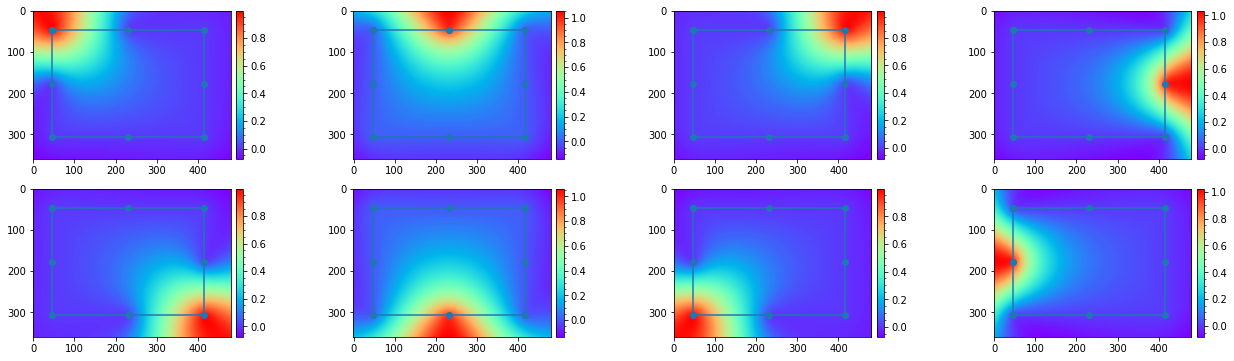

In [ ]:

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

cmap=plt.get_cmap("rainbow")

def show_gird_weight(img, src_cage, show_grid, col=2):
    fig1 = plt.figure(figsize=(22, 6))
    HW = show_grid.shape[-1]
    W = int(np.ceil(HW / col))
    for i in range(HW):
        plot_num = col*100+W*10+(i+1)
        ax1 = fig1.add_subplot(plot_num)
        im1 = ax1.imshow(show_grid[...,i].reshape(img.shape[0], img.shape[1], -1), cmap=cmap)
        ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
        cbar = fig1.colorbar(im1, ax=ax1, fraction=0.035, pad=0.02)
        cbar.minorticks_on()
        
show_gird_weight(img, src_cage, W_grid, col=2)
print(W_grid.min(), W_grid.max())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


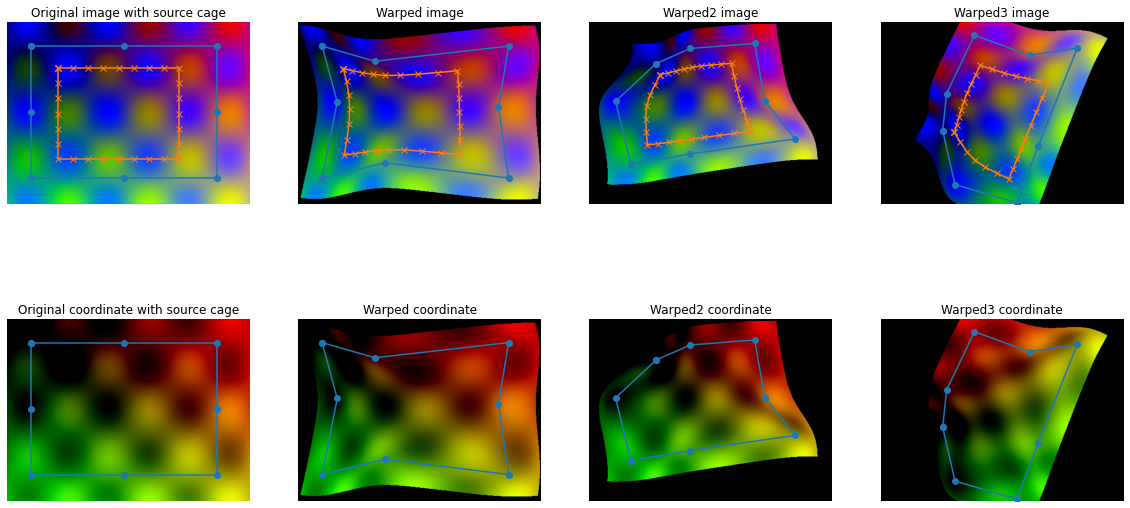

In [382]:

fig1 = plt.figure(figsize=(20, 10))

# Visualize
ax1 = fig1.add_subplot(241)

ax1.imshow(img)
ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
ax1.plot(np.r_[mesh_tgt[:,0], mesh_tgt[0,0]], np.r_[mesh_tgt[:,1], mesh_tgt[0,1]], '-x')
ax1.set_title("Original image with source cage")
ax1.axis('off')

ax2 = fig1.add_subplot(242)
ax2.imshow(warped)
ax2.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
ax2.plot(np.r_[mesh_tgt_deform[:,0], mesh_tgt_deform[0,0]], np.r_[mesh_tgt_deform[:,1], mesh_tgt_deform[0,1]], '-x')
ax2.set_title("Warped image")
ax2.axis('off')


ax2 = fig1.add_subplot(243)
ax2.imshow(warped2)
ax2.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax2.plot(np.r_[mesh_tgt_deform2[:,0], mesh_tgt_deform2[0,0]], np.r_[mesh_tgt_deform2[:,1], mesh_tgt_deform2[0,1]], '-x')
ax2.set_title("Warped2 image")
ax2.axis('off')

ax2 = fig1.add_subplot(244)
ax2.imshow(warped3)
ax2.plot(np.r_[deform3[:,0], deform3[0,0]], np.r_[deform3[:,1], deform3[0,1]], '-o')
ax2.plot(np.r_[mesh_tgt_deform3[:,0], mesh_tgt_deform3[0,0]], np.r_[mesh_tgt_deform3[:,1], mesh_tgt_deform3[0,1]], '-x')
ax2.set_title("Warped3 image")
ax2.axis('off')



ax3 = fig1.add_subplot(245)
ax3.imshow(cooord_bfr)
ax3.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
ax3.set_title("Original coordinate with source cage")
ax3.axis('off')

ax4 = fig1.add_subplot(246)
ax4.imshow(cooord_aft)
ax4.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
ax4.set_title("Warped coordinate")
ax4.axis('off')


ax6 = fig1.add_subplot(247)
ax6.imshow(cooord_aft2)
ax6.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax6.set_title("Warped2 coordinate")
ax6.axis('off')

ax6 = fig1.add_subplot(248)
ax6.imshow(cooord_aft3)
ax6.plot(np.r_[deform3[:,0], deform3[0,0]], np.r_[deform3[:,1], deform3[0,1]], '-o')
ax6.set_title("Warped3 coordinate")
ax6.axis('off')

plt.show()


# Learning MVC from data
Obtain cage weights using Neural Network (simple MLP)

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import random

class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, hid_dim=64, is_w=False, pou=False):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, hid_dim)
        self.fc4 = nn.Linear(hid_dim, hid_dim)
        self.fc5 = nn.Linear(hid_dim, hid_dim)
        self.fc6 = nn.Linear(hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(hid_dim, out_dim)
        self.act = nn.LeakyReLU(0.2)
        
        self.pou = pou
        self.is_w = is_w
        # if self.is_w:
        #     self.m_out = nn.Linear(hid_dim, out_dim)
        
    def forward(self, x_in, pou=False):
        """
        Args:
            x_in (torch.tensor): (B,N,in_dim)
        Returns
            out: (B,N,out_dim)
        """
        out1 = self.act(self.fc1(x_in))
        out2 = self.act(self.fc2(out1))
        out3 = self.act(self.fc3(out2))
        out4 = self.act(self.fc4(out3))
        out5 = self.act(self.fc5(out4))
        out6 = self.act(self.fc6(out5))
        
        out = self.fc_out(out6)
        
        if self.is_w:
            # out = out * torch.nn.Sigmoid()(self.m_out(out6)*10.0)
            # out = torch.nn.functional.normalize(out, dim=-2) # too much warping...
            
            # out = torch.nn.Sigmoid()(out)
            # out = torch.nn.Softplus()(out) # --- ripped ..!!
            # out = self.act(out) # -------------- ripped ...!!!
            # out = torch.nn.ELU(alpha=1.0)(out)
            out = torch.nn.ELU(alpha=0.5)(out)
            # out = torch.nn.ELU(alpha=0.3)(out)
            # out = torch.nn.ELU(alpha=0.1)(out)
            # out = torch.nn.ELU(alpha=0.05)(out)
            # out = torch.nn.LeakyReLU(0.2)(out)
            # out = out / (out.sum(dim=-1, keepdim=True)+1e-12) ## cause boundary collapse
            
        if self.pou:
            out = out / (out.sum(dim=-1, keepdim=True)+1e-12) ## cause boundary collapse
            
        return out

In [141]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## Learn mesh displacement directly!

In [ ]:

set_seed(42)

mesh_tgt_th = torch.tensor(mesh_tgt)[None].float()
mesh_tgt_deform_th = torch.tensor(mesh_tgt_deform)[None].float()
NV = mesh_tgt_th.shape[1]


src_cage_th = torch.tensor(src_cage).float()
deform_th = torch.tensor(deform).float()
CC = src_cage_th.shape[0]
NC = src_cage_th.reshape(-1).shape[0]


model = MLP(in_dim=2+NC)

optimizer = torch.optim.Adam([*model.parameters()], lr=5e-4)

model.train()

LW = 1/4

for i in tqdm(range(25_000)):
    optimizer.zero_grad()
    
    src_in = torch.cat([mesh_tgt_th, src_cage_th.reshape(1,1,-1).repeat(1,NV,1)],dim=-1)
    pred_mesh_tgt = model(src_in)
    
    def_in = torch.cat([mesh_tgt_th, deform_th.reshape(1,1,-1).repeat(1,NV,1)],dim=-1)
    pred_mesh_tgt_deform = model(def_in)
    
    loss = torch.nn.MSELoss()(mesh_tgt_th, pred_mesh_tgt) * LW
    loss += torch.nn.MSELoss()(mesh_tgt_deform_th, pred_mesh_tgt_deform) * LW
    
    
    cage_in_src = torch.cat([src_cage_th[None], src_cage_th.reshape(1,1,-1).repeat(1,CC,1)], dim=-1)
    pred_cage_src = model(cage_in_src)
    
    cage_in_def = torch.cat([src_cage_th[None], deform_th.reshape(1,1,-1).repeat(1,CC,1)],dim=-1)
    pred_cage_deform = model(cage_in_def)
    
    loss += torch.nn.MSELoss()(src_cage_th[None], pred_cage_src) * LW
    loss += torch.nn.MSELoss()(deform_th[None], pred_cage_deform) * LW
    
    loss.backward()
    optimizer.step()
    
    if i % 5000==0:
        print(i, loss.item())


  0%|          | 44/25000 [00:00<01:56, 214.25it/s]

0 50785.82421875


 20%|██        | 5018/25000 [00:23<01:30, 221.97it/s]

5000 2.061899185180664


 40%|████      | 10039/25000 [00:46<01:06, 223.35it/s]

10000 0.2183830887079239


 60%|██████    | 15040/25000 [01:09<00:47, 211.82it/s]

15000 0.05671197548508644


 80%|████████  | 20027/25000 [01:32<00:22, 224.09it/s]

20000 0.06155964732170105


100%|██████████| 25000/25000 [01:54<00:00, 217.44it/s]


## Learn to predict weight from cage data

In [305]:
## grid
margin=20
X_margin, Y_margin = np.meshgrid(np.arange(-margin, W+margin), np.arange(-margin,H+margin))
grid_margin = np.stack([X_margin.ravel(), Y_margin.ravel()], axis=1)

path = Path(src_cage)
inside_margin = path.contains_points(grid_margin)
grid_margin_in = grid_margin[inside_margin]
grid_margin_out = grid_margin[~inside_margin]


grid_margin_in_th = torch.tensor(grid_margin_in).float()
grid_margin_out_th = torch.tensor(grid_margin_out).float()

print(grid_margin_out_th.shape)

torch.Size([111691, 2])


In [ ]:
set_seed(42)

mesh_tgt_th = torch.tensor(mesh_tgt)[None].float()
mesh_tgt_deform_th = torch.tensor(mesh_tgt_deform)[None].float()
NV = mesh_tgt_th.shape[1]

src_cage_th = torch.tensor(src_cage).float()
# deform_th = torch.tensor(deform).float()
deform_th = torch.tensor(deform3).float()
CC = src_cage_th.shape[0]
NC = src_cage_th.reshape(-1).shape[0]

grid_th = torch.tensor(grid)[None].float()
NG = grid_th.shape[1]

# model2 = MLP(in_dim=2+NC, out_dim=src_cage.shape[0])
# model2 = MLP(in_dim=2+NC, out_dim=src_cage.shape[0], is_w=True)
# model2 = MLP(in_dim=2+NC, out_dim=src_cage.shape[0], pou=True)
model2 = MLP(in_dim=2+NC, out_dim=src_cage.shape[0], pou=True, is_w=True)

optimizer2 = torch.optim.Adam([*model2.parameters()], lr=5e-4)

model2.train()

LW = 1/3

src_in = torch.cat([mesh_tgt_th, src_cage_th.reshape(1,1,-1).repeat(1,NV,1)], dim=-1)
cage_in = torch.cat([src_cage_th[None], src_cage_th.reshape(1,1,-1).repeat(1,CC,1)], dim=-1)

H,W = img.shape[0], img.shape[1]
MX = H if H > W else W

for i in tqdm(range(25_000)):
    optimizer2.zero_grad()
    
    loss=0
    pred_mesh_W = model2(src_in)
    
    pred_mesh_tgt = pred_mesh_W @ src_cage_th
    # pred_mesh_tgt_deform = pred_mesh_W @ deform_th
    
    loss += torch.nn.L1Loss()(mesh_tgt_th, pred_mesh_tgt) * LW # linear precision
    # loss += torch.nn.L1Loss()(mesh_tgt_deform_th, pred_mesh_tgt_deform) * LW # linear precision
        
    ### ------------------------ lagrange property -----------------------
    pred_cage_W = model2(cage_in)
    # loss += torch.nn.L1Loss()(torch.eye(CC)[None], pred_cage_W) * LW 
    pred_cage_th = pred_cage_W @ src_cage_th
    pred_cage_th_deform = pred_cage_W @ deform_th
    
    loss += torch.nn.L1Loss()(src_cage_th[None], pred_cage_th) * LW
    loss += torch.nn.L1Loss()(deform_th[None], pred_cage_th_deform) * LW
    ### ------------------------------------------------------------------
    
    ### grid -------------------------------------------------------------
    _sample = 40
    ## random points from inside grid
    # _range = torch.randint(0, NG, (_sample,))
    # grid_th_ = grid_th[:,_range]
    
    ## random points from in and out grid
    # grid_th_ = torch.randint(-10, MX+10, (1, _sample,2))*1.0
    
    ## random points from outside grid
    _range = torch.randint(0, grid_margin_out_th.shape[0], (_sample,))
    grid_th_ = grid_margin_out_th[_range][None]
    
    grid_in = torch.cat([grid_th_, src_cage_th.reshape(1,1,-1).repeat(1,_sample,1)], dim=-1)
    pred_grid_W = model2(grid_in)
    pred_grid_th = pred_grid_W @ src_cage_th
    loss += torch.nn.L1Loss()(grid_th_, pred_grid_th) * LW
    ### ------------------------------------------------------------------
    
    ### partition of unity -----------------------------------------------
    # loss += torch.nn.L1Loss()(torch.ones(1,NV), pred_mesh_W.sum(-1)) * LW * 0.1
    # loss += torch.nn.L1Loss()(torch.ones(1,_sample), pred_grid_W.sum(-1)) * LW * 0.1
    # loss += torch.nn.L1Loss()(torch.ones(1,CC), pred_cage_W.sum(-1)) * LW * 0.1
    ### ------------------------------------------------------------------
    
    
    loss.backward()
    optimizer2.step()
    if i % 5000==0:
        print(i, loss.item())


  0%|          | 18/25000 [00:00<02:19, 179.26it/s]

0 149.77325439453125


 20%|██        | 5018/25000 [00:26<01:38, 201.94it/s]

5000 2.8440561294555664


 33%|███▎      | 8254/25000 [00:43<01:27, 190.83it/s]

In [248]:
# print(grid_th[:,20:])
# print(torch.randint(-20, MX+20, (1, 20,2))*1.0)

## Visualization

In [ ]:
# required data for visualization

src_cage_th = torch.tensor(src_cage).float()
deform_th = torch.tensor(deform).float()
deform2_th = torch.tensor(deform2).float()
deform3_th = torch.tensor(deform3).float()
grid_th = torch.tensor(grid)[None].float()

NG = grid_th.shape[1]
img_inside = img.copy()

torch.Size([1, 172800, 2])


In [ ]:
### Get output from displacement model
model.eval()

src_in = torch.cat([mesh_tgt_th, src_cage_th.reshape(1,1,-1).repeat(1,NV,1)], dim=-1)
def_in = torch.cat([mesh_tgt_th, deform_th.reshape(1,1,-1).repeat(1,NV,1)], dim=-1)
def2_in = torch.cat([mesh_tgt_th, deform2_th.reshape(1,1,-1).repeat(1,NV,1)], dim=-1)
def3_in = torch.cat([mesh_tgt_th, deform3_th.reshape(1,1,-1).repeat(1,NV,1)], dim=-1)

with torch.no_grad():
    pred_mesh_src = model(src_in).detach().cpu().numpy().squeeze()
    pred_mesh_def = model(def_in).detach().cpu().numpy().squeeze()
    pred_mesh_def2 = model(def2_in).detach().cpu().numpy().squeeze()
    pred_mesh_def3 = model(def3_in).detach().cpu().numpy().squeeze()
print(pred_mesh_src.shape)
print(pred_mesh_def.shape)
print(pred_mesh_def2.shape)
print(pred_mesh_def3.shape)

src_in_g = torch.cat([grid_th, src_cage_th.reshape(1,1,-1).repeat(1,NG,1)], dim=-1)
def_in_g = torch.cat([grid_th, deform_th.reshape(1,1,-1).repeat(1,NG,1)], dim=-1)
def2_in_g = torch.cat([grid_th, deform2_th.reshape(1,1,-1).repeat(1,NG,1)], dim=-1)
def3_in_g = torch.cat([grid_th, deform3_th.reshape(1,1,-1).repeat(1,NG,1)], dim=-1)

with torch.no_grad():
    pred_grid_src = model(src_in_g).detach().cpu().numpy().squeeze()
    pred_grid_src = pred_grid_src.reshape(img_inside.shape[0], img_inside.shape[1],-1)
    
    pred_grid_def = model(def_in_g).detach().cpu().numpy().squeeze()
    pred_grid_def = pred_grid_def.reshape(img_inside.shape[0], img_inside.shape[1],-1)
    
    pred_grid_def2 = model(def2_in_g).detach().cpu().numpy().squeeze()
    pred_grid_def2 = pred_grid_def2.reshape(img_inside.shape[0], img_inside.shape[1],-1)
    
    pred_grid_def3 = model(def3_in_g).detach().cpu().numpy().squeeze()
    pred_grid_def3 = pred_grid_def3.reshape(img_inside.shape[0], img_inside.shape[1],-1)
        
pred_rgb_src, wsum = forward_warp_fixed_canvas(img_inside, pred_grid_src, out_size=None)
pred_rgb_def, wsum = forward_warp_fixed_canvas(img_inside, pred_grid_def, out_size=None)
pred_rgb_def2, wsum = forward_warp_fixed_canvas(img_inside, pred_grid_def2, out_size=None)
pred_rgb_def3, wsum = forward_warp_fixed_canvas(img_inside, pred_grid_def3, out_size=None)

(29, 2)
(29, 2)
(29, 2)
(29, 2)


In [ ]:
### Get output from cage weight model
img_inside = img.copy()

model2.eval()

src_in = torch.cat([mesh_tgt_th, src_cage_th.reshape(1,1,-1).repeat(1,NV,1)], dim=-1)
src_in_g = torch.cat([grid_th, src_cage_th.reshape(1,1,-1).repeat(1,NG,1)], dim=-1)

with torch.no_grad():
    pred_mesh2_W = model2(src_in).detach().cpu().numpy().squeeze()
    
    pred_mesh2_src = pred_mesh2_W @ src_cage
    pred_mesh2_def = pred_mesh2_W @ deform
    pred_mesh2_def2 = pred_mesh2_W @ deform2
    pred_mesh2_def3 = pred_mesh2_W @ deform3
    
print(pred_mesh2_src.shape)
print(pred_mesh2_def.shape)
print(pred_mesh2_def2.shape)


with torch.no_grad():
    pred_grid2_W = model2(src_in_g).detach().cpu().numpy().squeeze()
    
    pred_grid2_src = pred_grid2_W @ src_cage
    pred_grid2_def = pred_grid2_W @ deform
    pred_grid2_def2 = pred_grid2_W @ deform2
    pred_grid2_def3 = pred_grid2_W @ deform3
    
print(pred_grid2_src.shape)
print(pred_grid2_def.shape)
print(pred_grid2_def2.shape)
        
pred_rgb2_src, wsum = forward_warp_fixed_canvas(img_inside, pred_grid2_src, out_size=None)
pred_rgb2_def, wsum = forward_warp_fixed_canvas(img_inside, pred_grid2_def, out_size=None)
pred_rgb2_def2, wsum = forward_warp_fixed_canvas(img_inside, pred_grid2_def2, out_size=None)
pred_rgb2_def3, wsum = forward_warp_fixed_canvas(img_inside, pred_grid2_def3, out_size=None)

(29, 2)
(29, 2)
(29, 2)
(172800, 2)
(172800, 2)
(172800, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


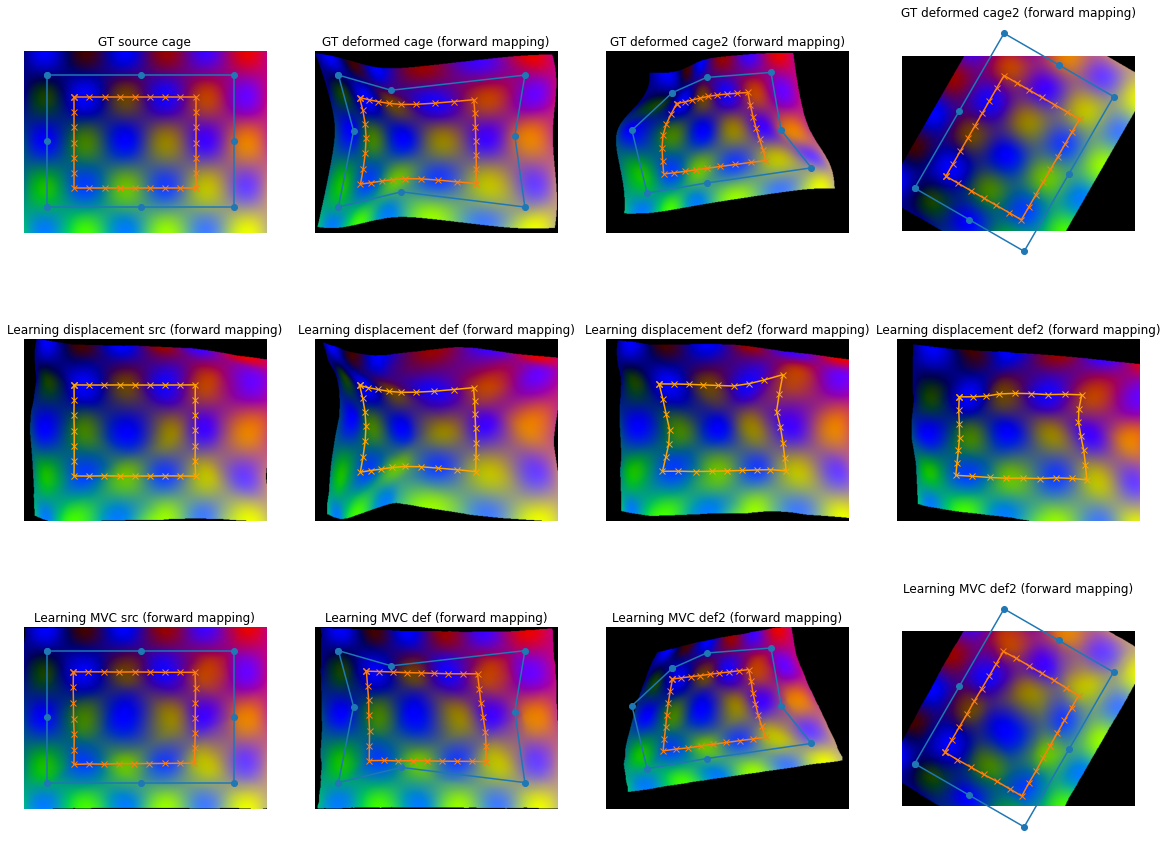

In [ ]:
fig1 = plt.figure(figsize=(20, 15))


# Visualize
ax1 = fig1.add_subplot(341)
ax1.imshow(img_inside)
ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
ax1.plot(np.r_[mesh_tgt[:,0], mesh_tgt[0,0]], np.r_[mesh_tgt[:,1], mesh_tgt[0,1]], '-x')
ax1.set_title("GT source cage")
ax1.axis('off')
# plt.show()

ax2 = fig1.add_subplot(342)
# diff_img = img-warped
# ax2.imshow(diff_img)
ax2.imshow(warped)
# warped_inside=warped.copy()
# warped_inside.reshape(-1,3)[~inside]=0
# ax2.imshow(warped_inside)
ax2.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
ax2.plot(np.r_[mesh_tgt_deform[:,0], mesh_tgt_deform[0,0]], np.r_[mesh_tgt_deform[:,1], mesh_tgt_deform[0,1]], '-x')
ax2.set_title("GT deformed cage (forward mapping)")
ax2.axis('off')

ax3 = fig1.add_subplot(343)

# warped2_inside = warped2.copy()
# warped2_inside.reshape(-1,3)[~inside_def2]=0
# ax3.imshow(warped2_inside)
ax3.imshow(warped2)
ax3.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax3.plot(
    np.r_[mesh_tgt_deform2[:,0], mesh_tgt_deform2[0,0]],
    np.r_[mesh_tgt_deform2[:,1], mesh_tgt_deform2[0,1]],
    '-x'
)
ax3.set_title("GT deformed cage2 (forward mapping)")
ax3.axis('off')
# plt.show()


ax3 = fig1.add_subplot(344)
# warped2_inside = warped2.copy()
# warped2_inside.reshape(-1,3)[~inside_def2]=0
# ax3.imshow(warped2_inside)
ax3.imshow(warped3)
ax3.plot(np.r_[deform3[:,0], deform3[0,0]], np.r_[deform3[:,1], deform3[0,1]], '-o')
ax3.plot(
    np.r_[mesh_tgt_deform3[:,0], mesh_tgt_deform3[0,0]],
    np.r_[mesh_tgt_deform3[:,1], mesh_tgt_deform3[0,1]],
    '-x'
)
ax3.set_title("GT deformed cage2 (forward mapping)")
ax3.axis('off')
# plt.show()





ax4 = fig1.add_subplot(345)
ax4.imshow(pred_rgb_src)
# ax4.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
ax4.plot(np.r_[pred_mesh_src[:,0], pred_mesh_src[0,0]], np.r_[pred_mesh_src[:,1], pred_mesh_src[0,1]], '-x', c='orange')
ax4.set_title("Learning displacement src (forward mapping)")
ax4.axis('off')
# plt.show()


ax5 = fig1.add_subplot(346)
ax5.imshow(pred_rgb_def)
# ax5.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
ax5.plot(np.r_[pred_mesh_def[:,0], pred_mesh_def[0,0]], np.r_[pred_mesh_def[:,1], pred_mesh_def[0,1]], '-x', c='orange')
ax5.set_title("Learning displacement def (forward mapping)")
ax5.axis('off')


ax6 = fig1.add_subplot(347)
ax6.imshow(pred_rgb_def2)
# ax6.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax6.plot(np.r_[pred_mesh_def2[:,0], pred_mesh_def2[0,0]], np.r_[pred_mesh_def2[:,1], pred_mesh_def2[0,1]], '-x', c='orange')
ax6.set_title("Learning displacement def2 (forward mapping)")
ax6.axis('off')

ax6 = fig1.add_subplot(348)
ax6.imshow(pred_rgb_def3)
# ax6.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax6.plot(np.r_[pred_mesh_def3[:,0], pred_mesh_def3[0,0]], np.r_[pred_mesh_def3[:,1], pred_mesh_def3[0,1]], '-x', c='orange')
ax6.set_title("Learning displacement def2 (forward mapping)")
ax6.axis('off')



# pred_mesh2_src
# pred_mesh2_def
# pred_mesh2_def2

# pred_rgb2_src
# pred_rgb2_def
# pred_rgb2_def2



ax7 = fig1.add_subplot(3,4,9)
ax7.imshow(pred_rgb2_src)
ax7.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
ax7.plot(np.r_[pred_mesh2_src[:,0], pred_mesh2_src[0,0]], np.r_[pred_mesh2_src[:,1], pred_mesh2_src[0,1]], '-x')
ax7.set_title("Learning MVC src (forward mapping)")
ax7.axis('off')

ax8 = fig1.add_subplot(3,4,10)
ax8.imshow(pred_rgb2_def)
ax8.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
ax8.plot(np.r_[pred_mesh2_def[:,0], pred_mesh2_def[0,0]], np.r_[pred_mesh2_def[:,1], pred_mesh2_def[0,1]], '-x')
ax8.set_title("Learning MVC def (forward mapping)")
ax8.axis('off')
# plt.show()

ax9 = fig1.add_subplot(3,4,11)
ax9.imshow(pred_rgb2_def2)
ax9.plot(np.r_[deform2[:,0], deform2[0,0]], np.r_[deform2[:,1], deform2[0,1]], '-o')
ax9.plot(
    np.r_[pred_mesh2_def2[:,0], pred_mesh2_def2[0,0]],
    np.r_[pred_mesh2_def2[:,1], pred_mesh2_def2[0,1]],
    '-x'
)
ax9.set_title("Learning MVC def2 (forward mapping)")
ax9.axis('off')

ax9 = fig1.add_subplot(3,4,12)
ax9.imshow(pred_rgb2_def3)
ax9.plot(np.r_[deform3[:,0], deform3[0,0]], np.r_[deform3[:,1], deform3[0,1]], '-o')
ax9.plot(
    np.r_[pred_mesh2_def3[:,0], pred_mesh2_def3[0,0]],
    np.r_[pred_mesh2_def3[:,1], pred_mesh2_def3[0,1]],
    '-x'
)
ax9.set_title("Learning MVC def2 (forward mapping)")
ax9.axis('off')

plt.show()


-0.08885067 1.247766
-0.14178386309625207 1.0630446629216577


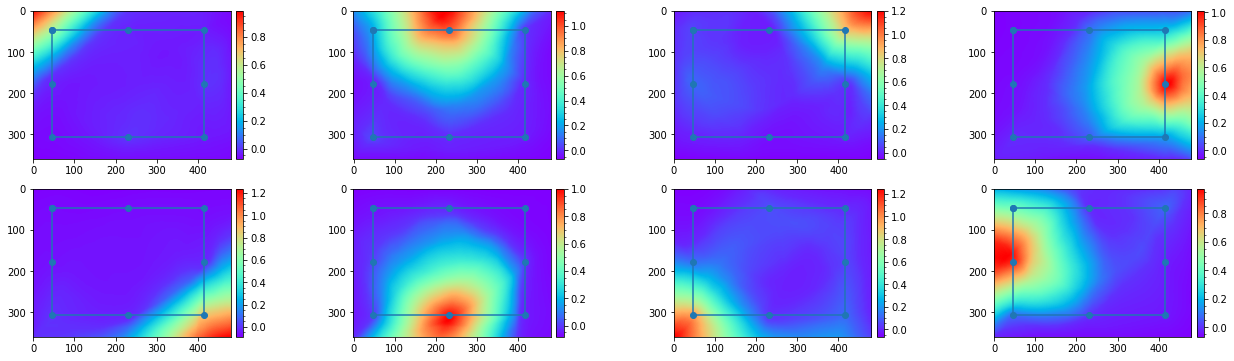

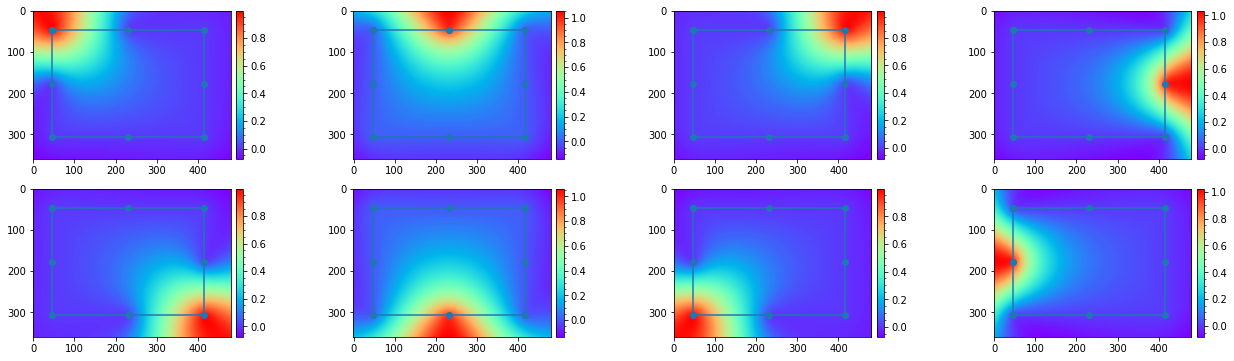

In [373]:
cmap=plt.get_cmap("rainbow")
show_grid=pred_grid2_W

def show_gird_weight(img, src_cage, show_grid, col=2):
    fig1 = plt.figure(figsize=(22, 6))
    HW = show_grid.shape[-1]
    W = int(np.ceil(HW / col))
    for i in range(HW):
        plot_num = col*100+W*10+(i+1)
        ax1 = fig1.add_subplot(plot_num)
        im1 = ax1.imshow(show_grid[...,i].reshape(img.shape[0], img.shape[1], -1), cmap=cmap)
        ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
        cbar = fig1.colorbar(im1, ax=ax1, fraction=0.035, pad=0.02)
        cbar.minorticks_on()
        
show_gird_weight(img, src_cage, show_grid, col=2)
print(show_grid.min(), show_grid.max())
show_gird_weight(img, src_cage, W_grid, col=2)
print(W_grid.min(), W_grid.max())